In [1]:
image_folder = 'C:/USers/zecharpy/Desktop/Licence-Plate-Recognition-Keras/num-plate-track/data/images/'
annot_folder = 'C:/USers/zecharpy/Desktop/Licence-Plate-Recognition-Keras/num-plate-track/data/annot/'


In [35]:
from __future__ import absolute_import, division, print_function
import numpy as np
import argparse
import random
import os
from scipy import misc
from skimage import draw
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint

def create_model(image_height, image_width, loss, optimizer):
    """Creates the cat face locator model.
    Args:
        image_height: The height of the input images.
        image_width: The width of the input images.
        loss: Keras loss function (name or object), e.g. "mse".
        optimizer: Keras optimizer to use, e.g. Adam() or "sgd".
    Returns:
        Sequential
    """

    model = Sequential()

    # 3x128x128
    model.add(Conv2D(32, (3, 3), padding="same", input_shape=(image_height, image_width,3)))
    model.add(Activation("relu"))
    model.add(Dropout(0.0))

    # 32x128x128
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(Dropout(0.0))

    # 32x128x128
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))

    # 64x64x64
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))

    # 128x32x32
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))

    # 128x16x16
    model.add(Conv2D(256, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))

    # 256x8x8 = 16384
    model.add(Flatten())

    model.add(Dense(256))
    model.add(Activation("sigmoid"))
    model.add(Dropout(0.5))

    model.add(Dense(4))
    model.add(Activation("linear"))

    # compile with mean squared error
    print("Compiling...")
    model.compile(loss=loss, optimizer=optimizer)

    return model

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(40,40))


def NMS_debug(ith, train_imgs, show=False, cnt=0):
    y_class=[]
    y_coor=[]
    cnt=0

    #print(y_true.shape)
    image=cv2.imread(train_imgs[ith]['filename'])

    for obj in train_imgs[ith]['object']:
        #print(ith,obj['xmin'], obj['ymin'], obj['xmax'], obj['ymax'])
        b=(obj['xmin'],obj['ymin'],obj['xmax'],obj['ymax'])
        
        xmin_norm=b[0]/256.
        ymin_norm=b[1]/256.
        box_width=(b[2]-b[0])/256.
        box_height=(b[3]-b[1])/256.
        y_coor.append(np.array([xmin_norm,ymin_norm,box_width, box_height]))
             
                
    if show:
        _x=int(xmin_norm*256)
        _y=int(ymin_norm*256)
        _w=int(box_width*256)
        _h=int(box_height*256)
        cv2.rectangle(image,(_x,_y),(_x+_w,_y+_h),(0,0,255),4)
        plt.figure(figsize=(30,30))
        plt.imshow(image[:,:,[2,1,0]])
        plt.show()
    return  y_coor

<Figure size 2880x2880 with 0 Axes>

In [4]:
import os
import cv2
import copy
import numpy as np

import xml.etree.ElementTree as ET


def parse_annotation_v2(ann_dir, img_dir, labels=[]):
    all_imgs = []
    seen_labels = {}
    
    for ann in sorted(os.listdir(ann_dir)):
        img = {'object':[]}

        tree = ET.parse(ann_dir + ann)
        
        for elem in tree.iter():
            if 'filename' in elem.tag:
                img['filename'] = img_dir + elem.text
            if 'width' in elem.tag:
                img['width'] = int(elem.text)
            if 'height' in elem.tag:
                img['height'] = int(elem.text)
            if 'object' in elem.tag or 'part' in elem.tag:
                obj = {}
                
                for attr in list(elem):
                    if 'name' in attr.tag:
                        obj['name'] = attr.text

                        if obj['name'] in seen_labels:
                            seen_labels[obj['name']] += 1
                        else:
                            seen_labels[obj['name']] = 1
                        
                        if len(labels) >= 1 and obj['name'] not in labels:
                            break
                        else:
                            img['object'] += [obj]
                            
                    if 'bndbox' in attr.tag:
                        for dim in list(attr):
                            if 'xmin' in dim.tag:
                                obj['xmin'] = int(round(float(dim.text)))
                            if 'ymin' in dim.tag:
                                obj['ymin'] = int(round(float(dim.text)))
                            if 'xmax' in dim.tag:
                                obj['xmax'] = int(round(float(dim.text)))
                            if 'ymax' in dim.tag:
                                obj['ymax'] = int(round(float(dim.text)))

        if len(img['object']) > 0:
            all_imgs += [img]
                        
    return all_imgs, seen_labels

imgs, labels = parse_annotation_v2(annot_folder,
                                                image_folder,
                                                'sv_licence_plate')




In [5]:
Y=[]
X=[]

cnt=0
flag=True
for i in range(len(imgs)):
    im=cv2.imread(imgs[i]['filename'])
    im=im/255
    #print(im.shape)
    X.append(im)
    if cnt>=3:
        flas=False
    y_coor=NMS_debug(i, imgs, False,cnt=cnt)
    Y.append(y_coor)
    cnt+=1
Y=np.array(Y)
Y=np.stack(Y, axis=0)
Y=Y.reshape(30,4)
X=np.array(X)


Y.shape, X.shape

((30, 4), (30, 256, 256, 3))

In [8]:
def calculate_iou(y_true, y_pred):
    
    
    """
    Input:
    Keras provides the input as numpy arrays with shape (batch_size, num_columns).
    
    Arguments:
    y_true -- first box, numpy array with format [x, y, width, height, conf_score]
    y_pred -- second box, numpy array with format [x, y, width, height, conf_score]
    x any y are the coordinates of the top left corner of each box.
    
    Output: IoU of type float32. (This is a ratio. Max is 1. Min is 0.)
    
    """

    
    results = []
    
    for i in range(0,y_true.shape[0]):
    
        # set the types so we are sure what type we are using
        y_true = y_true.astype(np.float32)
        y_pred = y_pred.astype(np.float32)


        # boxTrue
        x_boxTrue_tleft = y_true[0,0]  # numpy index selection
        y_boxTrue_tleft = y_true[0,1]
        boxTrue_width = y_true[0,2]
        boxTrue_height = y_true[0,3]
        area_boxTrue = (boxTrue_width * boxTrue_height)

        # boxPred
        x_boxPred_tleft = y_pred[0,0]
        y_boxPred_tleft = y_pred[0,1]
        boxPred_width = y_pred[0,2]
        boxPred_height = y_pred[0,3]
        area_boxPred = (boxPred_width * boxPred_height)


        # calculate the bottom right coordinates for boxTrue and boxPred

        # boxTrue
        x_boxTrue_br = x_boxTrue_tleft + boxTrue_width
        y_boxTrue_br = y_boxTrue_tleft + boxTrue_height # Version 2 revision

        # boxPred
        x_boxPred_br = x_boxPred_tleft + boxPred_width
        y_boxPred_br = y_boxPred_tleft + boxPred_height # Version 2 revision


        # calculate the top left and bottom right coordinates for the intersection box, boxInt

        # boxInt - top left coords
        x_boxInt_tleft = np.max([x_boxTrue_tleft,x_boxPred_tleft])
        y_boxInt_tleft = np.max([y_boxTrue_tleft,y_boxPred_tleft]) # Version 2 revision

        # boxInt - bottom right coords
        x_boxInt_br = np.min([x_boxTrue_br,x_boxPred_br])
        y_boxInt_br = np.min([y_boxTrue_br,y_boxPred_br]) 

        # Calculate the area of boxInt, i.e. the area of the intersection 
        # between boxTrue and boxPred.
        # The np.max() function forces the intersection area to 0 if the boxes don't overlap.
        
        
        # Version 2 revision
        area_of_intersection = \
        np.max([0,(x_boxInt_br - x_boxInt_tleft)]) * np.max([0,(y_boxInt_br - y_boxInt_tleft)])

        iou = area_of_intersection / ((area_boxTrue + area_boxPred) - area_of_intersection)


        # This must match the type used in py_func
        iou = iou.astype(np.float32)
        
        # append the result to a list at the end of each loop
        results.append(iou)
    
    # return the mean IoU score for the batch
    return np.mean(results)

def IoU(y_true, y_pred):
    
    # Note: the type float32 is very important. It must be the same type as the output from
    # the python function above or you too may spend many late night hours 
    # trying to debug and almost give up.
    
    iou = tf.py_func(calculate_iou, [y_true, y_pred], tf.float32)

    return iou

In [36]:
"""
# do not run unless you want to retrain
from keras.models import load_model
import tensorflow as tf
checkpoint = ModelCheckpoint('ckpoint_LicencePlate.h5', verbose=1, monitor='val_loss',save_best_only=True)
# Returns a compiled model identical to the previous one
m= create_model(256, 256, 'mse', 'Adam')
m.compile(optimizer='Adam', loss='mse', metrics=[IoU])
"""



Compiling...


In [50]:
# do not run unless you want to retrain
#m.fit(X[:-8],Y[:-8],epochs=2000,batch_size=8,initial_epoch=1000,shuffle=True,callbacks=[checkpoint], validation_data=(X[-8:],Y[-8:]))

Train on 30 samples, validate on 8 samples
Epoch 1001/2000
30/30 [==============================] - 5s 160ms/step - loss: 0.0025 - IoU: 0.2187 - val_loss: 0.0698 - val_IoU: 0.0000e+00

Epoch 01001: val_loss did not improve from 0.06395
Epoch 1002/2000
30/30 [==============================] - 5s 161ms/step - loss: 0.0021 - IoU: 0.2357 - val_loss: 0.0771 - val_IoU: 0.0000e+00

Epoch 01002: val_loss did not improve from 0.06395
Epoch 1003/2000
30/30 [==============================] - 5s 154ms/step - loss: 0.0022 - IoU: 0.3971 - val_loss: 0.0936 - val_IoU: 0.0000e+00

Epoch 01003: val_loss did not improve from 0.06395
Epoch 1004/2000
30/30 [==============================] - 5s 152ms/step - loss: 0.0020 - IoU: 0.2733 - val_loss: 0.0730 - val_IoU: 0.0000e+00

Epoch 01004: val_loss did not improve from 0.06395
Epoch 1005/2000
30/30 [==============================] - 5s 152ms/step - loss: 0.0015 - IoU: 0.2928 - val_loss: 0.0605 - val_IoU: 0.0000e+00

Epoch 01005: val_loss improved from 0.06395

30/30 [==============================] - 5s 152ms/step - loss: 0.0022 - IoU: 0.1225 - val_loss: 0.0741 - val_IoU: 0.0000e+00

Epoch 01043: val_loss did not improve from 0.06054
Epoch 1044/2000
30/30 [==============================] - 5s 159ms/step - loss: 0.0019 - IoU: 0.2080 - val_loss: 0.0707 - val_IoU: 0.0000e+00

Epoch 01044: val_loss did not improve from 0.06054
Epoch 1045/2000
30/30 [==============================] - 5s 150ms/step - loss: 0.0015 - IoU: 0.3325 - val_loss: 0.0720 - val_IoU: 0.0000e+00

Epoch 01045: val_loss did not improve from 0.06054
Epoch 1046/2000
30/30 [==============================] - 5s 151ms/step - loss: 0.0014 - IoU: 0.1024 - val_loss: 0.0772 - val_IoU: 0.0000e+00

Epoch 01046: val_loss did not improve from 0.06054
Epoch 1047/2000
30/30 [==============================] - 6s 214ms/step - loss: 0.0023 - IoU: 0.0827 - val_loss: 0.0758 - val_IoU: 0.0000e+00

Epoch 01047: val_loss did not improve from 0.06054
Epoch 1048/2000
30/30 [============================

Epoch 1085/2000
30/30 [==============================] - 6s 186ms/step - loss: 0.0023 - IoU: 0.2316 - val_loss: 0.0582 - val_IoU: 0.0000e+00

Epoch 01085: val_loss did not improve from 0.04349
Epoch 1086/2000
30/30 [==============================] - 5s 169ms/step - loss: 0.0016 - IoU: 0.2276 - val_loss: 0.0575 - val_IoU: 0.0000e+00

Epoch 01086: val_loss did not improve from 0.04349
Epoch 1087/2000
30/30 [==============================] - 5s 159ms/step - loss: 0.0016 - IoU: 0.3037 - val_loss: 0.0369 - val_IoU: 0.0000e+00

Epoch 01087: val_loss improved from 0.04349 to 0.03692, saving model to ckpoint_LicencePlate.h5
Epoch 1088/2000
30/30 [==============================] - 5s 156ms/step - loss: 0.0025 - IoU: 0.2945 - val_loss: 0.0372 - val_IoU: 0.0000e+00

Epoch 01088: val_loss did not improve from 0.03692
Epoch 1089/2000
30/30 [==============================] - 5s 151ms/step - loss: 0.0027 - IoU: 0.1168 - val_loss: 0.0503 - val_IoU: 0.0000e+00

Epoch 01089: val_loss did not improve fro

30/30 [==============================] - 5s 176ms/step - loss: 0.0018 - IoU: 0.2468 - val_loss: 0.0509 - val_IoU: 0.0000e+00

Epoch 01127: val_loss did not improve from 0.03692
Epoch 1128/2000
30/30 [==============================] - 5s 168ms/step - loss: 0.0022 - IoU: 0.1899 - val_loss: 0.0595 - val_IoU: 0.0000e+00

Epoch 01128: val_loss did not improve from 0.03692
Epoch 1129/2000
30/30 [==============================] - 5s 169ms/step - loss: 0.0020 - IoU: 0.4118 - val_loss: 0.0578 - val_IoU: 0.0000e+00

Epoch 01129: val_loss did not improve from 0.03692
Epoch 1130/2000
30/30 [==============================] - 5s 154ms/step - loss: 0.0017 - IoU: 0.3495 - val_loss: 0.0486 - val_IoU: 0.0000e+00

Epoch 01130: val_loss did not improve from 0.03692
Epoch 1131/2000
30/30 [==============================] - 5s 164ms/step - loss: 0.0014 - IoU: 0.2182 - val_loss: 0.0456 - val_IoU: 0.0000e+00

Epoch 01131: val_loss did not improve from 0.03692
Epoch 1132/2000
30/30 [============================

30/30 [==============================] - 6s 210ms/step - loss: 0.0016 - IoU: 0.2303 - val_loss: 0.0324 - val_IoU: 0.0000e+00

Epoch 01169: val_loss did not improve from 0.02980
Epoch 1170/2000
30/30 [==============================] - 6s 191ms/step - loss: 0.0011 - IoU: 0.2528 - val_loss: 0.0343 - val_IoU: 0.0000e+00

Epoch 01170: val_loss did not improve from 0.02980
Epoch 1171/2000
30/30 [==============================] - 5s 170ms/step - loss: 0.0015 - IoU: 0.3955 - val_loss: 0.0301 - val_IoU: 0.0000e+00

Epoch 01171: val_loss did not improve from 0.02980
Epoch 1172/2000
30/30 [==============================] - 5s 160ms/step - loss: 0.0021 - IoU: 0.4363 - val_loss: 0.0294 - val_IoU: 0.0000e+00

Epoch 01172: val_loss improved from 0.02980 to 0.02937, saving model to ckpoint_LicencePlate.h5
Epoch 1173/2000
30/30 [==============================] - 5s 155ms/step - loss: 0.0020 - IoU: 0.3355 - val_loss: 0.0363 - val_IoU: 0.0000e+00

Epoch 01173: val_loss did not improve from 0.02937
Epoch 

30/30 [==============================] - 6s 188ms/step - loss: 0.0015 - IoU: 0.3135 - val_loss: 0.0433 - val_IoU: 0.0000e+00

Epoch 01211: val_loss did not improve from 0.02937
Epoch 1212/2000
30/30 [==============================] - 5s 171ms/step - loss: 0.0022 - IoU: 0.3975 - val_loss: 0.0411 - val_IoU: 0.0000e+00

Epoch 01212: val_loss did not improve from 0.02937
Epoch 1213/2000
30/30 [==============================] - 5s 161ms/step - loss: 0.0022 - IoU: 0.5963 - val_loss: 0.0381 - val_IoU: 0.0000e+00

Epoch 01213: val_loss did not improve from 0.02937
Epoch 1214/2000
30/30 [==============================] - 5s 162ms/step - loss: 0.0015 - IoU: 0.3339 - val_loss: 0.0438 - val_IoU: 0.0000e+00

Epoch 01214: val_loss did not improve from 0.02937
Epoch 1215/2000
30/30 [==============================] - 5s 151ms/step - loss: 0.0011 - IoU: 0.1885 - val_loss: 0.0451 - val_IoU: 0.0000e+00

Epoch 01215: val_loss did not improve from 0.02937
Epoch 1216/2000
30/30 [============================


Epoch 01252: val_loss did not improve from 0.02139
Epoch 1253/2000
30/30 [==============================] - 6s 186ms/step - loss: 0.0013 - IoU: 0.2979 - val_loss: 0.0241 - val_IoU: 0.0000e+00

Epoch 01253: val_loss did not improve from 0.02139
Epoch 1254/2000
30/30 [==============================] - 5s 169ms/step - loss: 0.0016 - IoU: 0.2910 - val_loss: 0.0302 - val_IoU: 0.0000e+00

Epoch 01254: val_loss did not improve from 0.02139
Epoch 1255/2000
30/30 [==============================] - 5s 164ms/step - loss: 0.0016 - IoU: 0.3056 - val_loss: 0.0287 - val_IoU: 0.0000e+00

Epoch 01255: val_loss did not improve from 0.02139
Epoch 1256/2000
30/30 [==============================] - 5s 153ms/step - loss: 0.0014 - IoU: 0.5053 - val_loss: 0.0283 - val_IoU: 0.0000e+00

Epoch 01256: val_loss did not improve from 0.02139
Epoch 1257/2000
30/30 [==============================] - 5s 152ms/step - loss: 0.0015 - IoU: 0.1871 - val_loss: 0.0299 - val_IoU: 0.0286

Epoch 01257: val_loss did not improve 

30/30 [==============================] - 5s 154ms/step - loss: 0.0014 - IoU: 0.3844 - val_loss: 0.0229 - val_IoU: 0.0222

Epoch 01295: val_loss did not improve from 0.02005
Epoch 1296/2000
30/30 [==============================] - 6s 188ms/step - loss: 0.0022 - IoU: 0.5619 - val_loss: 0.0162 - val_IoU: 0.0000e+00

Epoch 01296: val_loss improved from 0.02005 to 0.01618, saving model to ckpoint_LicencePlate.h5
Epoch 1297/2000
30/30 [==============================] - 6s 187ms/step - loss: 0.0022 - IoU: 0.1584 - val_loss: 0.0194 - val_IoU: 0.0000e+00

Epoch 01297: val_loss did not improve from 0.01618
Epoch 1298/2000
30/30 [==============================] - 5s 164ms/step - loss: 0.0011 - IoU: 0.3843 - val_loss: 0.0265 - val_IoU: 0.1054

Epoch 01298: val_loss did not improve from 0.01618
Epoch 1299/2000
30/30 [==============================] - 5s 158ms/step - loss: 0.0017 - IoU: 0.2846 - val_loss: 0.0220 - val_IoU: 0.1521

Epoch 01299: val_loss did not improve from 0.01618
Epoch 1300/2000
30

30/30 [==============================] - 5s 156ms/step - loss: 0.0017 - IoU: 0.4886 - val_loss: 0.0221 - val_IoU: 0.0000e+00

Epoch 01337: val_loss did not improve from 0.01580
Epoch 1338/2000
30/30 [==============================] - 5s 152ms/step - loss: 0.0015 - IoU: 0.2761 - val_loss: 0.0193 - val_IoU: 0.0000e+00

Epoch 01338: val_loss did not improve from 0.01580
Epoch 1339/2000
30/30 [==============================] - 5s 160ms/step - loss: 0.0014 - IoU: 0.1273 - val_loss: 0.0164 - val_IoU: 0.0000e+00

Epoch 01339: val_loss did not improve from 0.01580
Epoch 1340/2000
30/30 [==============================] - 5s 160ms/step - loss: 0.0018 - IoU: 0.3296 - val_loss: 0.0220 - val_IoU: 0.0000e+00

Epoch 01340: val_loss did not improve from 0.01580
Epoch 1341/2000
30/30 [==============================] - 5s 154ms/step - loss: 0.0028 - IoU: 0.1334 - val_loss: 0.0142 - val_IoU: 0.0000e+00

Epoch 01341: val_loss improved from 0.01580 to 0.01416, saving model to ckpoint_LicencePlate.h5
Epoch 

30/30 [==============================] - 5s 152ms/step - loss: 0.0012 - IoU: 0.3635 - val_loss: 0.0142 - val_IoU: 0.0000e+00

Epoch 01379: val_loss did not improve from 0.01163
Epoch 1380/2000
30/30 [==============================] - 7s 236ms/step - loss: 0.0012 - IoU: 0.3450 - val_loss: 0.0160 - val_IoU: 0.0000e+00

Epoch 01380: val_loss did not improve from 0.01163
Epoch 1381/2000
30/30 [==============================] - 6s 206ms/step - loss: 0.0011 - IoU: 0.3023 - val_loss: 0.0158 - val_IoU: 0.0000e+00

Epoch 01381: val_loss did not improve from 0.01163
Epoch 1382/2000
30/30 [==============================] - 6s 185ms/step - loss: 0.0015 - IoU: 0.3090 - val_loss: 0.0156 - val_IoU: 0.0000e+00

Epoch 01382: val_loss did not improve from 0.01163
Epoch 1383/2000
30/30 [==============================] - 5s 178ms/step - loss: 0.0013 - IoU: 0.2351 - val_loss: 0.0155 - val_IoU: 0.0000e+00

Epoch 01383: val_loss did not improve from 0.01163
Epoch 1384/2000
30/30 [============================


Epoch 01420: val_loss did not improve from 0.00666
Epoch 1421/2000
30/30 [==============================] - 5s 165ms/step - loss: 0.0011 - IoU: 0.3182 - val_loss: 0.0073 - val_IoU: 0.1712

Epoch 01421: val_loss did not improve from 0.00666
Epoch 1422/2000
30/30 [==============================] - 4s 149ms/step - loss: 0.0017 - IoU: 0.2450 - val_loss: 0.0088 - val_IoU: 0.2456

Epoch 01422: val_loss did not improve from 0.00666
Epoch 1423/2000
30/30 [==============================] - 6s 190ms/step - loss: 0.0012 - IoU: 0.3677 - val_loss: 0.0081 - val_IoU: 0.1310

Epoch 01423: val_loss did not improve from 0.00666
Epoch 1424/2000
30/30 [==============================] - 5s 183ms/step - loss: 0.0013 - IoU: 0.1041 - val_loss: 0.0063 - val_IoU: 0.0000e+00

Epoch 01424: val_loss improved from 0.00666 to 0.00630, saving model to ckpoint_LicencePlate.h5
Epoch 1425/2000
30/30 [==============================] - 5s 164ms/step - loss: 0.0016 - IoU: 0.1137 - val_loss: 0.0069 - val_IoU: 0.0000e+00

E

30/30 [==============================] - 5s 161ms/step - loss: 0.0013 - IoU: 0.2369 - val_loss: 0.0050 - val_IoU: 0.3437

Epoch 01463: val_loss improved from 0.00533 to 0.00499, saving model to ckpoint_LicencePlate.h5
Epoch 1464/2000
30/30 [==============================] - 5s 159ms/step - loss: 0.0010 - IoU: 0.1169 - val_loss: 0.0052 - val_IoU: 0.3266

Epoch 01464: val_loss did not improve from 0.00499
Epoch 1465/2000
30/30 [==============================] - 5s 162ms/step - loss: 6.7672e-04 - IoU: 0.6020 - val_loss: 0.0064 - val_IoU: 0.1798

Epoch 01465: val_loss did not improve from 0.00499
Epoch 1466/2000
30/30 [==============================] - 5s 171ms/step - loss: 0.0011 - IoU: 0.3598 - val_loss: 0.0065 - val_IoU: 0.1057

Epoch 01466: val_loss did not improve from 0.00499
Epoch 1467/2000
30/30 [==============================] - 6s 189ms/step - loss: 0.0013 - IoU: 0.1101 - val_loss: 0.0056 - val_IoU: 0.0418

Epoch 01467: val_loss did not improve from 0.00499
Epoch 1468/2000
30/30 


Epoch 01505: val_loss did not improve from 0.00386
Epoch 1506/2000
30/30 [==============================] - 5s 153ms/step - loss: 0.0014 - IoU: 0.3119 - val_loss: 0.0050 - val_IoU: 0.3738

Epoch 01506: val_loss did not improve from 0.00386
Epoch 1507/2000
30/30 [==============================] - 5s 150ms/step - loss: 0.0017 - IoU: 0.0925 - val_loss: 0.0058 - val_IoU: 0.3758

Epoch 01507: val_loss did not improve from 0.00386
Epoch 1508/2000
30/30 [==============================] - 6s 186ms/step - loss: 0.0010 - IoU: 0.4839 - val_loss: 0.0057 - val_IoU: 0.4021

Epoch 01508: val_loss did not improve from 0.00386
Epoch 1509/2000
30/30 [==============================] - 5s 172ms/step - loss: 0.0014 - IoU: 0.5748 - val_loss: 0.0051 - val_IoU: 0.3762

Epoch 01509: val_loss did not improve from 0.00386
Epoch 1510/2000
30/30 [==============================] - 5s 170ms/step - loss: 0.0016 - IoU: 0.2700 - val_loss: 0.0057 - val_IoU: 0.0753

Epoch 01510: val_loss did not improve from 0.00386
Epo


Epoch 01548: val_loss did not improve from 0.00288
Epoch 1549/2000
30/30 [==============================] - 5s 181ms/step - loss: 0.0013 - IoU: 0.4238 - val_loss: 0.0048 - val_IoU: 0.3641

Epoch 01549: val_loss did not improve from 0.00288
Epoch 1550/2000
30/30 [==============================] - 5s 173ms/step - loss: 0.0014 - IoU: 0.2830 - val_loss: 0.0028 - val_IoU: 0.4572

Epoch 01550: val_loss improved from 0.00288 to 0.00280, saving model to ckpoint_LicencePlate.h5
Epoch 1551/2000
30/30 [==============================] - 5s 163ms/step - loss: 0.0012 - IoU: 0.3789 - val_loss: 0.0028 - val_IoU: 0.4920

Epoch 01551: val_loss improved from 0.00280 to 0.00279, saving model to ckpoint_LicencePlate.h5
Epoch 1552/2000
30/30 [==============================] - 5s 158ms/step - loss: 0.0015 - IoU: 0.5503 - val_loss: 0.0039 - val_IoU: 0.4802

Epoch 01552: val_loss did not improve from 0.00279
Epoch 1553/2000
30/30 [==============================] - 5s 160ms/step - loss: 0.0012 - IoU: 0.2724 - 


Epoch 01590: val_loss did not improve from 0.00155
Epoch 1591/2000
30/30 [==============================] - 5s 157ms/step - loss: 0.0013 - IoU: 0.2705 - val_loss: 0.0029 - val_IoU: 0.1901

Epoch 01591: val_loss did not improve from 0.00155
Epoch 1592/2000
30/30 [==============================] - 5s 156ms/step - loss: 0.0012 - IoU: 0.5140 - val_loss: 0.0046 - val_IoU: 0.2314

Epoch 01592: val_loss did not improve from 0.00155
Epoch 1593/2000
30/30 [==============================] - 6s 209ms/step - loss: 0.0014 - IoU: 0.3071 - val_loss: 0.0040 - val_IoU: 0.3162

Epoch 01593: val_loss did not improve from 0.00155
Epoch 1594/2000
30/30 [==============================] - 6s 188ms/step - loss: 0.0013 - IoU: 0.4066 - val_loss: 0.0033 - val_IoU: 0.5578

Epoch 01594: val_loss did not improve from 0.00155
Epoch 1595/2000
30/30 [==============================] - 5s 174ms/step - loss: 9.9829e-04 - IoU: 0.4958 - val_loss: 0.0030 - val_IoU: 0.6564

Epoch 01595: val_loss did not improve from 0.00155

30/30 [==============================] - 5s 170ms/step - loss: 0.0011 - IoU: 0.3716 - val_loss: 0.0040 - val_IoU: 0.1920

Epoch 01634: val_loss did not improve from 0.00155
Epoch 1635/2000
30/30 [==============================] - 5s 164ms/step - loss: 0.0012 - IoU: 0.3801 - val_loss: 0.0046 - val_IoU: 0.1722

Epoch 01635: val_loss did not improve from 0.00155
Epoch 1636/2000
30/30 [==============================] - 5s 158ms/step - loss: 9.9714e-04 - IoU: 0.6659 - val_loss: 0.0038 - val_IoU: 0.4660

Epoch 01636: val_loss did not improve from 0.00155
Epoch 1637/2000
30/30 [==============================] - 5s 152ms/step - loss: 0.0011 - IoU: 0.2860 - val_loss: 0.0038 - val_IoU: 0.4490

Epoch 01637: val_loss did not improve from 0.00155
Epoch 1638/2000
30/30 [==============================] - 5s 154ms/step - loss: 0.0012 - IoU: 0.3684 - val_loss: 0.0050 - val_IoU: 0.4180

Epoch 01638: val_loss did not improve from 0.00155
Epoch 1639/2000
30/30 [==============================] - 6s 201ms/s

30/30 [==============================] - 7s 223ms/step - loss: 0.0018 - IoU: 0.4917 - val_loss: 0.0058 - val_IoU: 0.1775

Epoch 01677: val_loss did not improve from 0.00155
Epoch 1678/2000
30/30 [==============================] - 6s 192ms/step - loss: 0.0012 - IoU: 0.1178 - val_loss: 0.0070 - val_IoU: 0.3094

Epoch 01678: val_loss did not improve from 0.00155
Epoch 1679/2000
30/30 [==============================] - 5s 172ms/step - loss: 0.0013 - IoU: 0.4685 - val_loss: 0.0069 - val_IoU: 0.5415

Epoch 01679: val_loss did not improve from 0.00155
Epoch 1680/2000
30/30 [==============================] - 5s 167ms/step - loss: 0.0017 - IoU: 0.4588 - val_loss: 0.0060 - val_IoU: 0.5356

Epoch 01680: val_loss did not improve from 0.00155
Epoch 1681/2000
30/30 [==============================] - 5s 158ms/step - loss: 0.0015 - IoU: 0.4437 - val_loss: 0.0040 - val_IoU: 0.5294

Epoch 01681: val_loss did not improve from 0.00155
Epoch 1682/2000
30/30 [==============================] - 5s 153ms/step 

30/30 [==============================] - 7s 232ms/step - loss: 0.0013 - IoU: 0.3470 - val_loss: 0.0038 - val_IoU: 0.5478

Epoch 01720: val_loss did not improve from 0.00155
Epoch 1721/2000
30/30 [==============================] - 6s 202ms/step - loss: 0.0011 - IoU: 0.3263 - val_loss: 0.0029 - val_IoU: 0.3557

Epoch 01721: val_loss did not improve from 0.00155
Epoch 1722/2000
30/30 [==============================] - 5s 171ms/step - loss: 0.0015 - IoU: 0.3150 - val_loss: 0.0030 - val_IoU: 0.3266

Epoch 01722: val_loss did not improve from 0.00155
Epoch 1723/2000
30/30 [==============================] - 5s 166ms/step - loss: 0.0014 - IoU: 0.4242 - val_loss: 0.0034 - val_IoU: 0.3931

Epoch 01723: val_loss did not improve from 0.00155
Epoch 1724/2000
30/30 [==============================] - 5s 164ms/step - loss: 0.0012 - IoU: 0.2983 - val_loss: 0.0032 - val_IoU: 0.4036

Epoch 01724: val_loss did not improve from 0.00155
Epoch 1725/2000
30/30 [==============================] - 5s 152ms/step 

30/30 [==============================] - 5s 153ms/step - loss: 0.0015 - IoU: 0.2091 - val_loss: 0.0045 - val_IoU: 0.1399

Epoch 01763: val_loss did not improve from 0.00155
Epoch 1764/2000
30/30 [==============================] - 5s 152ms/step - loss: 9.2388e-04 - IoU: 0.5258 - val_loss: 0.0039 - val_IoU: 0.3414

Epoch 01764: val_loss did not improve from 0.00155
Epoch 1765/2000
30/30 [==============================] - 5s 154ms/step - loss: 0.0019 - IoU: 0.1098 - val_loss: 0.0041 - val_IoU: 0.4814

Epoch 01765: val_loss did not improve from 0.00155
Epoch 1766/2000
30/30 [==============================] - 6s 206ms/step - loss: 8.3039e-04 - IoU: 0.6352 - val_loss: 0.0050 - val_IoU: 0.5080

Epoch 01766: val_loss did not improve from 0.00155
Epoch 1767/2000
30/30 [==============================] - 6s 193ms/step - loss: 9.8456e-04 - IoU: 0.4703 - val_loss: 0.0054 - val_IoU: 0.3594

Epoch 01767: val_loss did not improve from 0.00155
Epoch 1768/2000
30/30 [==============================] - 5s

30/30 [==============================] - 5s 159ms/step - loss: 0.0018 - IoU: 0.2289 - val_loss: 0.0052 - val_IoU: 0.1160

Epoch 01806: val_loss did not improve from 0.00155
Epoch 1807/2000
30/30 [==============================] - 4s 150ms/step - loss: 0.0013 - IoU: 0.4401 - val_loss: 0.0065 - val_IoU: 0.0000e+00

Epoch 01807: val_loss did not improve from 0.00155
Epoch 1808/2000
30/30 [==============================] - 6s 199ms/step - loss: 0.0017 - IoU: 0.0174 - val_loss: 0.0077 - val_IoU: 0.0000e+00

Epoch 01808: val_loss did not improve from 0.00155
Epoch 1809/2000
30/30 [==============================] - 5s 179ms/step - loss: 0.0015 - IoU: 0.4448 - val_loss: 0.0090 - val_IoU: 0.1610

Epoch 01809: val_loss did not improve from 0.00155
Epoch 1810/2000
30/30 [==============================] - 5s 169ms/step - loss: 0.0017 - IoU: 0.2695 - val_loss: 0.0086 - val_IoU: 0.3973

Epoch 01810: val_loss did not improve from 0.00155
Epoch 1811/2000
30/30 [==============================] - 5s 162

30/30 [==============================] - 5s 164ms/step - loss: 0.0015 - IoU: 0.5170 - val_loss: 0.0088 - val_IoU: 0.1247

Epoch 01849: val_loss did not improve from 0.00155
Epoch 1850/2000
30/30 [==============================] - 5s 164ms/step - loss: 0.0013 - IoU: 0.5253 - val_loss: 0.0076 - val_IoU: 0.1967

Epoch 01850: val_loss did not improve from 0.00155
Epoch 1851/2000
30/30 [==============================] - 6s 208ms/step - loss: 0.0011 - IoU: 0.4722 - val_loss: 0.0061 - val_IoU: 0.3229

Epoch 01851: val_loss did not improve from 0.00155
Epoch 1852/2000
30/30 [==============================] - 6s 190ms/step - loss: 0.0011 - IoU: 0.3025 - val_loss: 0.0050 - val_IoU: 0.3746

Epoch 01852: val_loss did not improve from 0.00155
Epoch 1853/2000
30/30 [==============================] - 5s 178ms/step - loss: 0.0010 - IoU: 0.3069 - val_loss: 0.0046 - val_IoU: 0.2813

Epoch 01853: val_loss did not improve from 0.00155
Epoch 1854/2000
30/30 [==============================] - 5s 163ms/step 

30/30 [==============================] - 5s 165ms/step - loss: 0.0016 - IoU: 0.3850 - val_loss: 0.0048 - val_IoU: 0.5180

Epoch 01892: val_loss did not improve from 0.00155
Epoch 1893/2000
30/30 [==============================] - 5s 154ms/step - loss: 0.0012 - IoU: 0.4371 - val_loss: 0.0062 - val_IoU: 0.1367

Epoch 01893: val_loss did not improve from 0.00155
Epoch 1894/2000
30/30 [==============================] - 6s 197ms/step - loss: 0.0017 - IoU: 0.1683 - val_loss: 0.0071 - val_IoU: 0.0256

Epoch 01894: val_loss did not improve from 0.00155
Epoch 1895/2000
30/30 [==============================] - 6s 191ms/step - loss: 0.0018 - IoU: 0.4412 - val_loss: 0.0074 - val_IoU: 0.1152

Epoch 01895: val_loss did not improve from 0.00155
Epoch 1896/2000
30/30 [==============================] - 5s 180ms/step - loss: 9.8312e-04 - IoU: 0.2501 - val_loss: 0.0070 - val_IoU: 0.4483

Epoch 01896: val_loss did not improve from 0.00155
Epoch 1897/2000
30/30 [==============================] - 5s 160ms/s

30/30 [==============================] - 5s 164ms/step - loss: 0.0016 - IoU: 0.3064 - val_loss: 0.0085 - val_IoU: 0.0000e+00

Epoch 01935: val_loss did not improve from 0.00155
Epoch 1936/2000
30/30 [==============================] - 5s 163ms/step - loss: 0.0015 - IoU: 0.2764 - val_loss: 0.0086 - val_IoU: 0.0000e+00

Epoch 01936: val_loss did not improve from 0.00155
Epoch 1937/2000
30/30 [==============================] - 5s 157ms/step - loss: 0.0011 - IoU: 0.1606 - val_loss: 0.0072 - val_IoU: 0.1301

Epoch 01937: val_loss did not improve from 0.00155
Epoch 1938/2000
30/30 [==============================] - 5s 152ms/step - loss: 0.0015 - IoU: 0.2125 - val_loss: 0.0075 - val_IoU: 0.1222

Epoch 01938: val_loss did not improve from 0.00155
Epoch 1939/2000
30/30 [==============================] - 5s 154ms/step - loss: 0.0012 - IoU: 0.3893 - val_loss: 0.0071 - val_IoU: 0.1473

Epoch 01939: val_loss did not improve from 0.00155
Epoch 1940/2000
30/30 [==============================] - 6s 195

30/30 [==============================] - 6s 198ms/step - loss: 9.3744e-04 - IoU: 0.3931 - val_loss: 0.0069 - val_IoU: 0.2552

Epoch 01978: val_loss did not improve from 0.00155
Epoch 1979/2000
30/30 [==============================] - 6s 199ms/step - loss: 0.0011 - IoU: 0.3425 - val_loss: 0.0062 - val_IoU: 0.2118

Epoch 01979: val_loss did not improve from 0.00155
Epoch 1980/2000
30/30 [==============================] - 5s 181ms/step - loss: 0.0012 - IoU: 0.1583 - val_loss: 0.0052 - val_IoU: 0.2607

Epoch 01980: val_loss did not improve from 0.00155
Epoch 1981/2000
30/30 [==============================] - 5s 165ms/step - loss: 0.0012 - IoU: 0.2340 - val_loss: 0.0046 - val_IoU: 0.3440

Epoch 01981: val_loss did not improve from 0.00155
Epoch 1982/2000
30/30 [==============================] - 5s 163ms/step - loss: 0.0011 - IoU: 0.4005 - val_loss: 0.0044 - val_IoU: 0.3188

Epoch 01982: val_loss did not improve from 0.00155
Epoch 1983/2000
30/30 [==============================] - 5s 161ms/s

In [51]:
# serialize model to JSON
from keras.models import model_from_json
model_json = m.to_json()
with open("LicencePlate_IOU_Loss.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
m.save_weights("LicencePlate_IOU_Loss.h5")
print("Saved model to disk")
 
# later...

# load json and create model
json_file = open('LicencePlate_IOU_Loss.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("LicencePlate_IOU_Loss.h5")
loaded_model.compile(optimizer='Adam', loss='mse', metrics=[IoU])

Saved model to disk


0006.jpg
pred [0.46579844 0.6852849  0.1686899  0.0781347 ]
true [0.5078125  0.734375   0.16015625 0.04296875]
true 130 188 41 11
pred 119 175 43 20


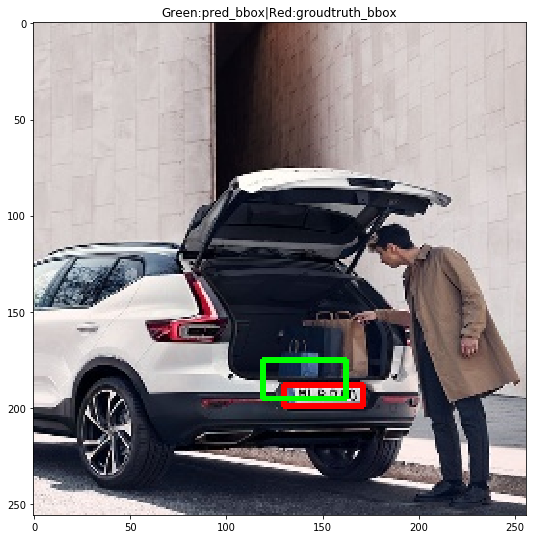

0001.jpg
pred [0.3055588  0.6502782  0.15342255 0.0690519 ]
true [0.27734375 0.640625   0.1640625  0.06640625]
true 71 164 42 17
pred 78 166 39 17


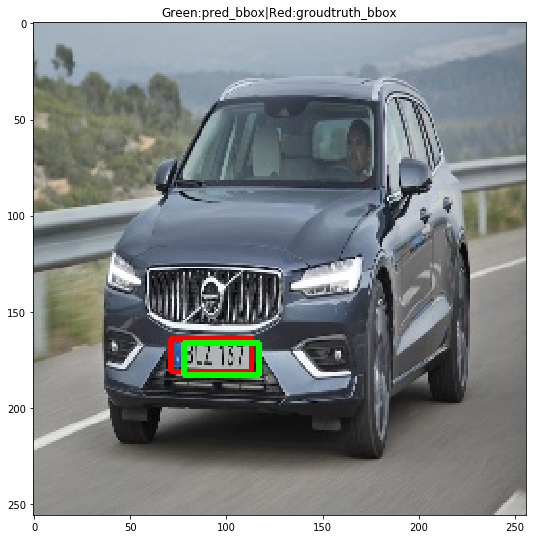

0001.jpg
pred [0.3055588  0.6502782  0.15342255 0.0690519 ]
true [0.27734375 0.640625   0.1640625  0.06640625]
true 71 164 42 17
pred 78 166 39 17


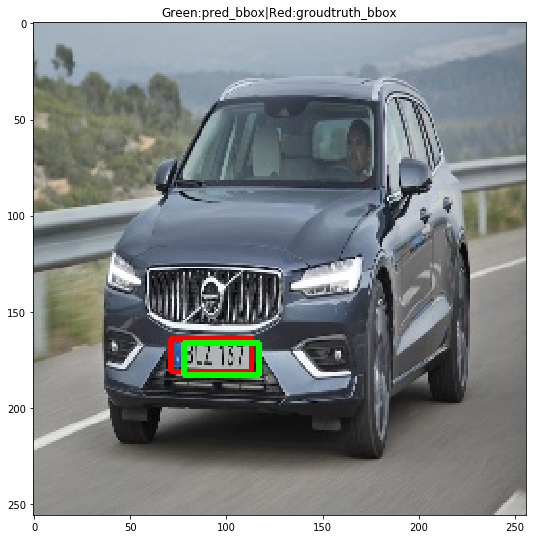

In [56]:
%matplotlib inline

import random
#model.save('licence_plat_bbox_se.h5')
val_ls=os.listdir(image_folder)
max_image_displayed=3
for i in range(max_image_displayed):
    plt.figure(figsize=(30,20))
    plt.subplot(1,max_image_displayed,i+1)
    rn=random.randint(0,len(val_ls)-1)
    print(val_ls[rn])
    im=cv2.imread(image_folder+val_ls[rn])
    ye = loaded_model.predict(im.reshape(1,256,256,3))
    x,y,w,h=[int(k) for k in ye[0]*256]
    print("pred",ye[0])
    tx,ty,tw,th=[int(k) for k in Y[rn]*256]
    print("true",Y[rn])
    print("true",tx,ty,tw,th)
    print("pred",x,y,w,h)
    cv2.rectangle(im, (tx,ty),(tx+tw,ty+th), (0,0,255),2)
    cv2.rectangle(im,(x,y),(x+w,y+h),(0,255,0),2)

    plt.imshow(im[:,:,[2,1,0]])
    plt.title("Green:pred_bbox|Red:groudtruth_bbox")
    plt.show()